### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [91]:
df=pd.read_excel("BG_sample10.xlsx")

In [92]:
df.shape

(797, 14)

In [93]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,400,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,60,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,매우 낮음,NaN,NaN,Android,55,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [95]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [96]:
df['Event'].value_counts()

EGV     769
교정        9
경고        6
인슐린       5
건강        2
탄수화물      2
장치        1
이름        1
생년월일      1
성         1
Name: Event, dtype: int64

In [97]:
df['Glucose'].value_counts()

높음     29
270    16
272    14
257    14
267    14
       ..
225     1
224     1
221     1
216     1
55      1
Name: Glucose, Length: 205, dtype: int64

In [98]:
df.tail()

,Timestamp,Event,Glucose,Insulin,Meal
792,2019-12-27T07:06:54,인슐린,NaN,15.0,NaN
793,2019-12-27T07:08:11,EGV,266,NaN,NaN
794,2019-12-27T07:13:11,EGV,267,NaN,NaN
795,2019-12-27T07:18:11,EGV,268,NaN,NaN
796,2019-12-27T07:23:11,EGV,271,NaN,NaN


In [99]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

15.0    3
20.0    1
16.0    1
Name: Insulin, dtype: int64

In [100]:
# 식사 횟수
df['Meal'].value_counts()

200.0    1
60.0     1
Name: Meal, dtype: int64

In [101]:
df[35:50]

,Timestamp,Event,Glucose,Insulin,Meal
35,2019-12-24T17:03:26,EGV,347,NaN,NaN
36,2019-12-24T17:08:25,EGV,357,NaN,NaN
37,2019-12-24T17:13:26,EGV,359,NaN,NaN
38,2019-12-24T17:18:26,EGV,356,NaN,NaN
39,2019-12-24T17:23:26,EGV,355,NaN,NaN
40,2019-12-24T17:28:26,EGV,355,NaN,NaN
41,2019-12-24T17:33:26,EGV,352,NaN,NaN
42,2019-12-24T17:38:25,EGV,353,NaN,NaN
43,2019-12-24T17:43:24,EGV,351,NaN,NaN
44,2019-12-24T17:48:25,EGV,350,NaN,NaN


In [102]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [103]:
df.head(20)

,Timestamp,Event,Glucose,Insulin,Meal
10,2019-12-24T15:10:57,교정,333,NaN,NaN
11,2019-12-24T15:20:02,교정,358,NaN,NaN
12,2019-12-24T15:20:34,건강,NaN,NaN,NaN
13,2019-12-24T15:23:32,EGV,345,NaN,NaN
14,2019-12-24T15:28:32,교정,371,NaN,NaN
15,2019-12-24T15:28:37,건강,NaN,NaN,NaN
16,2019-12-24T15:28:52,EGV,353,NaN,NaN
17,2019-12-24T15:33:26,EGV,353,NaN,NaN
18,2019-12-24T15:38:25,EGV,354,NaN,NaN
19,2019-12-24T15:43:26,EGV,355,NaN,NaN


In [104]:
df.shape

(787, 5)

In [105]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [106]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,2019-12-24T15:10:57,교정,333,NaN,NaN
1,2019-12-24T15:20:02,교정,358,NaN,NaN
2,2019-12-24T15:20:34,건강,NaN,NaN,NaN
3,2019-12-24T15:23:32,EGV,345,NaN,NaN
4,2019-12-24T15:28:32,교정,371,NaN,NaN
5,2019-12-24T15:28:37,건강,NaN,NaN,NaN
6,2019-12-24T15:28:52,EGV,353,NaN,NaN
7,2019-12-24T15:33:26,EGV,353,NaN,NaN
8,2019-12-24T15:38:25,EGV,354,NaN,NaN
9,2019-12-24T15:43:26,EGV,355,NaN,NaN


In [107]:
df.shape

(787, 5)

In [108]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [109]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [110]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [111]:
def isNaN(num):
    return num==num

In [112]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [113]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [114]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [115]:
glucose_count_high(df,'Glucose')

높음 :  29


In [116]:
print('높음 개수 :',len(high_list))

높음 개수 : 29


In [117]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [118]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [119]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [120]:
low_list

[]

In [121]:
calibration_count_low(df,'Event')

교정 :  9


In [122]:
calib_list

[0, 1, 4, 74, 183, 369, 477, 659, 768]

In [123]:
insul_count(df,'Insulin')

인슐린 :  5


In [124]:
insulin_list

[75, 324, 371, 491, 782]

In [125]:
meal_count(df,'Meal')

식사 횟수 :  2


In [126]:
meal_list

[37, 326]

In [127]:
df['Insulin'].value_counts()

15.0    3
20.0    1
16.0    1
Name: Insulin, dtype: int64

In [128]:
df['Meal'].value_counts()

200.0    1
60.0     1
Name: Meal, dtype: int64

In [129]:
isNaN(df['Glucose'][14])

True

In [130]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=df['Insulin'][i]
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=df['Insulin'][i]
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=df['Insulin'][i]
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=df['Insulin'][i]
        continue

In [131]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=df['Meal'][i]
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=df['Meal'][i]
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=df['Meal'][i]
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=df['Meal'][i]
        continue

In [132]:
import math
math.isnan(df['Glucose'][14])

False

In [133]:
insulin_list

[75, 324, 371, 491, 782]

In [134]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [135]:
insulin_list

[75, 324, 371, 491, 782, 37, 326]

In [136]:
df=df.drop(insulin_list)

In [137]:
df[0:20]

,Timestamp,Event,Glucose,Insulin,Meal
0,2019-12-24T15:10:57,교정,333,NaN,NaN
1,2019-12-24T15:20:02,교정,358,NaN,NaN
2,2019-12-24T15:20:34,건강,NaN,NaN,NaN
3,2019-12-24T15:23:32,EGV,345,NaN,NaN
4,2019-12-24T15:28:32,교정,371,NaN,NaN
5,2019-12-24T15:28:37,건강,NaN,NaN,NaN
6,2019-12-24T15:28:52,EGV,353,NaN,NaN
7,2019-12-24T15:33:26,EGV,353,NaN,NaN
8,2019-12-24T15:38:25,EGV,354,NaN,NaN
9,2019-12-24T15:43:26,EGV,355,NaN,NaN


In [138]:
#isNaN(df['Insulin'][2])

In [139]:
df.isnull().sum()

Timestamp      0
Event          0
Glucose        2
Insulin      775
Meal         778
dtype: int64

In [140]:
df['Event'].value_counts()

EGV    769
교정       9
건강       2
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [141]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400

In [142]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [143]:
fix_glucose(df,'Glucose')

In [144]:
fix_glucose_low(df,'Glucose')

In [145]:
df['Glucose'].value_counts()

400    30
270    16
257    14
267    14
272    14
       ..
212     1
209     1
205     1
204     1
279     1
Name: Glucose, Length: 202, dtype: int64

In [146]:
df=df.dropna(subset=['Glucose'])

In [147]:
#df['Insulin'].value_counts()

In [148]:
df.isnull().sum()

Timestamp      0
Event          0
Glucose        0
Insulin      773
Meal         776
dtype: int64

In [149]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [150]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [151]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

#for i in range(len(df)):
#    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
#        new_insul_and_meal_list.append(i)
#    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
#        new_insul_list.append(i)
#    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
#        new_meal_list.append(i)
for i in range(len(df)):
    if (isNaN(df['Insulin'][i]) and isNaN(df['Meal'][i])):
        new_insul_and_meal_list.append(i)
    if (isNaN(df['Insulin'][i]) and isNaN(df['Meal'][i]==False)):
        new_insul_list.append(i)
    if (isNaN(df['Insulin'][i]==False) and isNaN(df['Meal'][i])):
        new_meal_list.append(i)

In [152]:
new_meal_list

[35, 321]

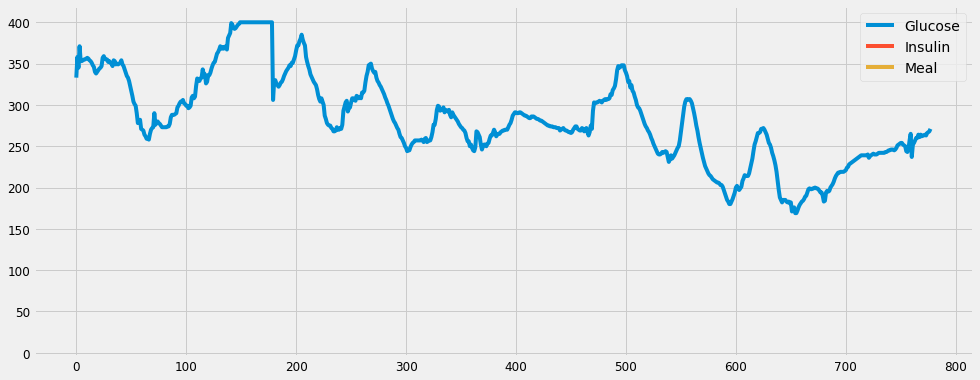

In [153]:
df.plot(figsize=(15,6))
plt.show()

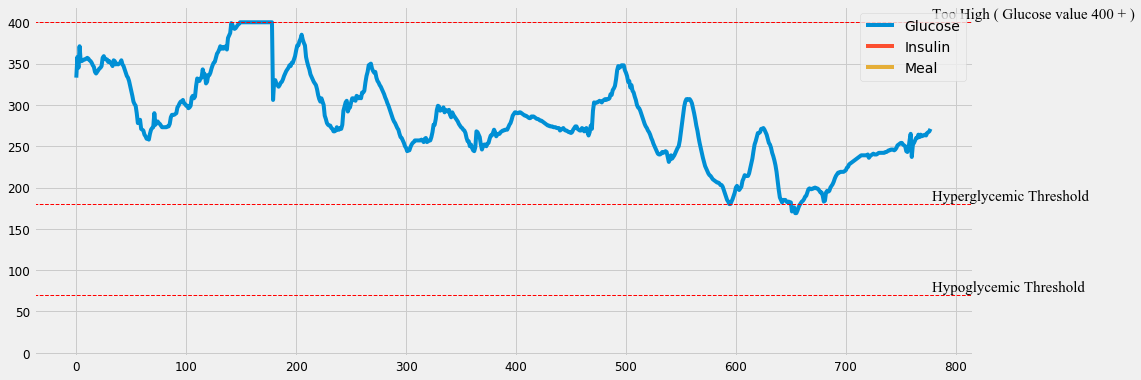

In [154]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [155]:
#df.drop(0,inplace=True)

In [156]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [157]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [158]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [159]:
#interpolate_glucose(df,'Glucose')

In [160]:
#meal

In [161]:
#insul

In [162]:
df[0:20]

,Timestamp,Event,Glucose,Insulin,Meal
0,2019-12-24T15:10:57,교정,333,NaN,NaN
1,2019-12-24T15:20:02,교정,358,NaN,NaN
2,2019-12-24T15:23:32,EGV,345,NaN,NaN
3,2019-12-24T15:28:32,교정,371,NaN,NaN
4,2019-12-24T15:28:52,EGV,353,NaN,NaN
5,2019-12-24T15:33:26,EGV,353,NaN,NaN
6,2019-12-24T15:38:25,EGV,354,NaN,NaN
7,2019-12-24T15:43:26,EGV,355,NaN,NaN
8,2019-12-24T15:48:25,EGV,355,NaN,NaN
9,2019-12-24T15:53:26,EGV,356,NaN,NaN


In [163]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [164]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [165]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [166]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
df.head(30)

,Timestamp,Event,Glucose,Insulin,Meal
0,2019-12-24T15:10:57,교정,333,NaN,NaN
1,2019-12-24T15:20:02,교정,358,NaN,NaN
2,2019-12-24T15:23:32,EGV,345,NaN,NaN
3,2019-12-24T15:28:32,교정,371,NaN,NaN
4,2019-12-24T15:28:52,EGV,353,NaN,NaN
5,2019-12-24T15:33:26,EGV,353,NaN,NaN
6,2019-12-24T15:38:25,EGV,354,NaN,NaN
7,2019-12-24T15:43:26,EGV,355,NaN,NaN
8,2019-12-24T15:48:25,EGV,355,NaN,NaN
9,2019-12-24T15:53:26,EGV,356,NaN,NaN


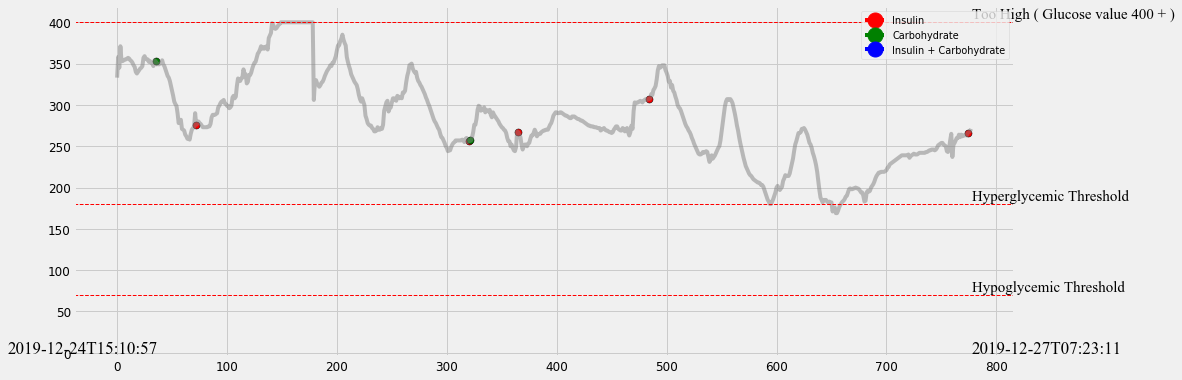

In [167]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [168]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        continue
    else:
        df['Insulin'][i]=0
        
     

In [169]:
isNaN(df['Insulin'][2])

True

In [170]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        continue
    else:
        df['Meal'][i]=0
        

In [173]:
df[315:325]

,Timestamp,Event,Glucose,Insulin,Meal
315,2019-12-25T17:13:20,EGV,257,0.0,0.0
316,2019-12-25T17:18:20,EGV,255,0.0,0.0
317,2019-12-25T17:23:21,EGV,259,0.0,0.0
318,2019-12-25T17:28:20,EGV,260,0.0,0.0
319,2019-12-25T17:33:20,EGV,255,0.0,0.0
320,2019-12-25T17:38:20,EGV,256,15.0,0.0
321,2019-12-25T17:43:20,EGV,257,0.0,200.0
322,2019-12-25T17:48:20,EGV,257,0.0,0.0
323,2019-12-25T17:53:21,EGV,261,0.0,0.0
324,2019-12-25T17:58:21,EGV,267,0.0,0.0


## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [174]:
import numpy as np
import tensorflow as tf
import random as rn

In [175]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [176]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [177]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [178]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [179]:
from numpy import array
from numpy import hstack
in_seq1=df['Glucose'].to_numpy()
in_seq2 =df['Meal'].to_numpy()
in_seq3 =df['Insulin'].to_numpy()
out_seq = array([in_seq1[i]+in_seq2[i]+in_seq3[i] for i in range(len(in_seq1))])

In [180]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [181]:
dataset = hstack((in_seq1,in_seq2,in_seq3))

In [182]:
dataset = np.asarray(dataset).astype(np.float32)

## 15분

In [183]:
def multi_data(dataset,target,start_index,end_index, history_size, target_size, step, single_step=False):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i, step)
        
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        #data.append(np.reshape(dataset[indices],(history_size)))
        #labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [184]:
raw_seq = in_seq1
#raw_seq=raw_seq.to_numpy(dtype='int64')

In [185]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 2
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [192]:
y_train_single

array([355., 356., 357., 356., 354., 353., 351., 348., 346., 340., 338.,
       340., 342., 344., 345., 347., 357., 359., 356., 355., 355., 352.,
       353., 351., 350., 347., 354., 353., 349., 350., 349., 350., 351.,
       354., 349., 347., 343., 339., 335., 333., 329., 323., 317., 311.,
       304., 301., 299., 290., 278., 281., 282., 271., 270., 269., 264.,
       262., 259., 260., 258., 265., 270., 272., 273., 290., 276., 278.,
       280., 278., 277., 275., 273., 273., 273., 273., 273., 274., 274.,
       277., 285., 288., 288., 288., 289., 290., 297., 299., 302., 304.,
       304., 306., 302., 301., 299., 299., 296., 297., 299., 309., 311.,
       308., 310., 323., 332., 329., 329., 332., 333., 343., 337., 337.,
       326., 328., 336., 336., 339., 344., 348., 351., 352., 357., 362.,
       364., 367., 371., 368., 370., 368., 370., 371., 367., 381., 384.,
       387., 399., 397., 393., 392., 393., 395., 397., 398., 400., 400.,
       400., 400., 400., 400., 400., 400., 400., 40

### RNN - 15분

In [97]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [98]:
from keras.layers import SimpleRNN

In [99]:
n_steps = 3
#delay=3
n_features=1

In [100]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [101]:
x_train_single.shape[-2:]

(6, 3)

In [102]:
K.set_session(sess)

In [103]:
model = Sequential()
#model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [104]:
model.compile(optimizer='adam',loss='mse')

In [105]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [106]:
K.clear_session()

In [107]:
predict_result = model.predict(x_val_single,verbose=0)

In [108]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [109]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_15 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  10.255667


#### Validation

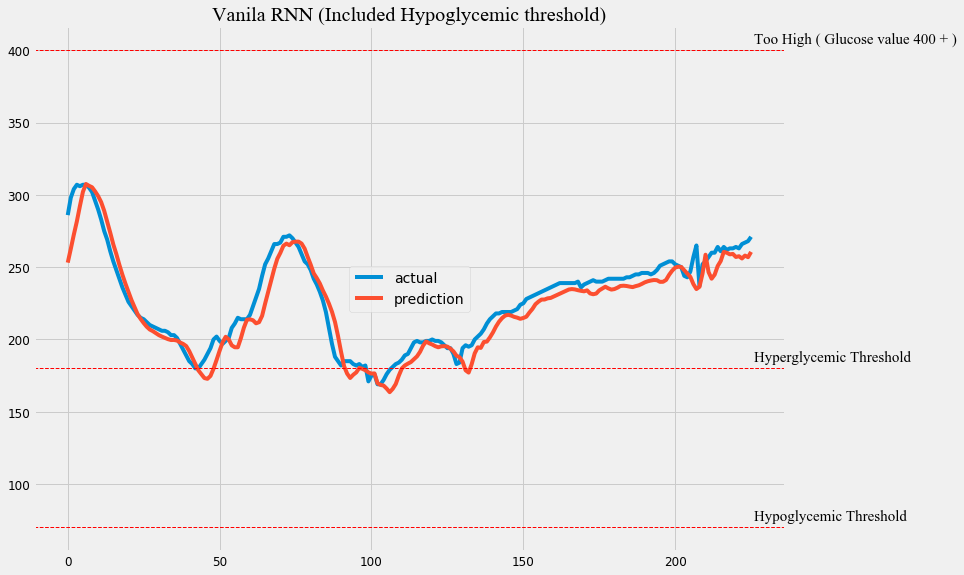

In [110]:
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [111]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

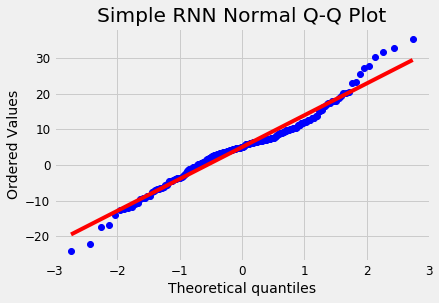

In [112]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

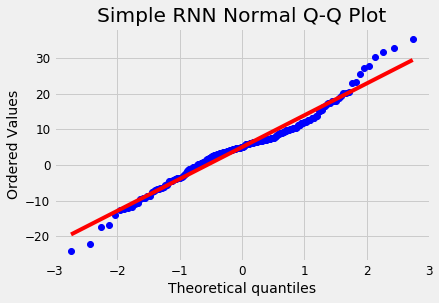

In [113]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [114]:
residuals=DataFrame(residuals)

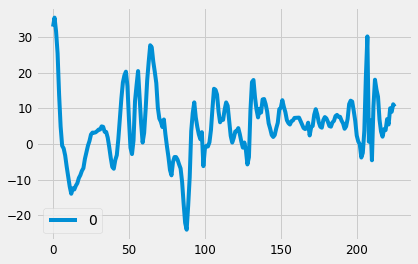

In [115]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001353DEFEA90>]],
      dtype=object)

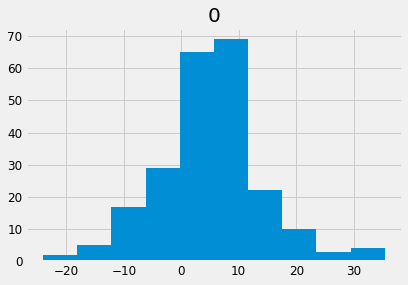

In [116]:

residuals.hist()

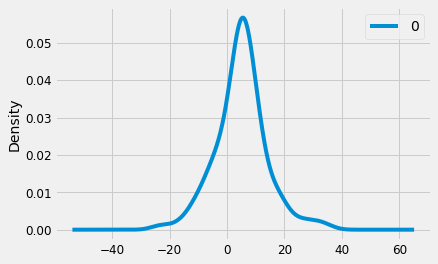

In [117]:
residuals.plot(kind='kde')

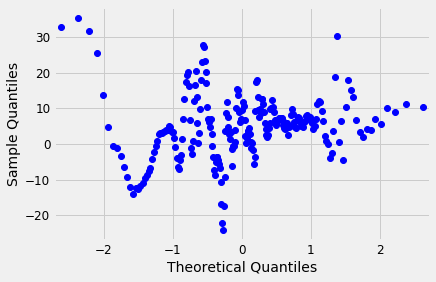

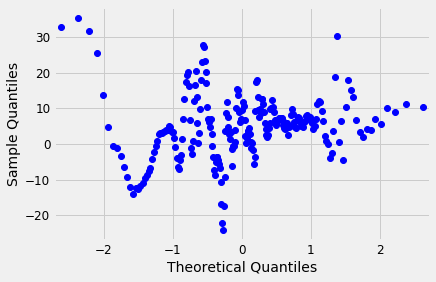

In [118]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [119]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_15=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  12.007007


#### Train

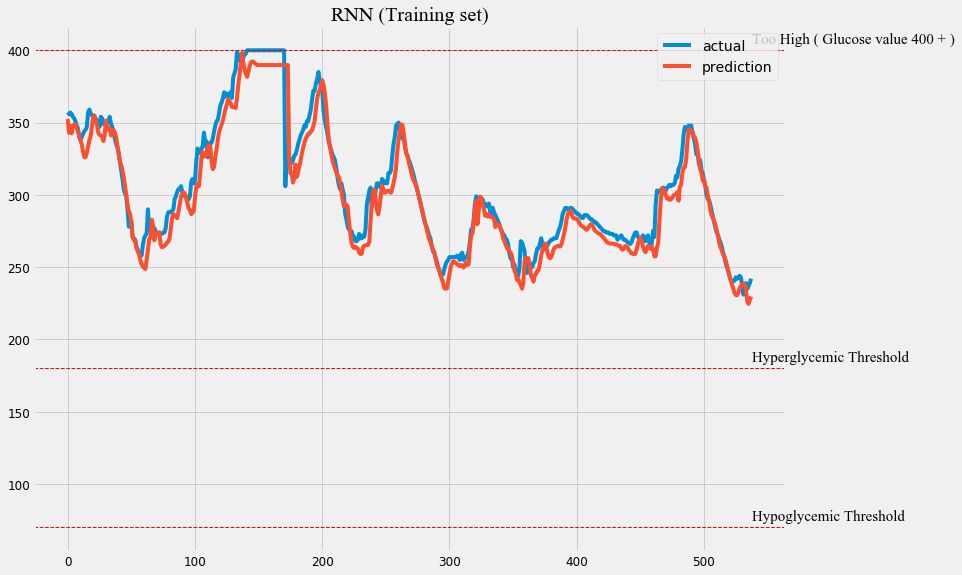

In [120]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

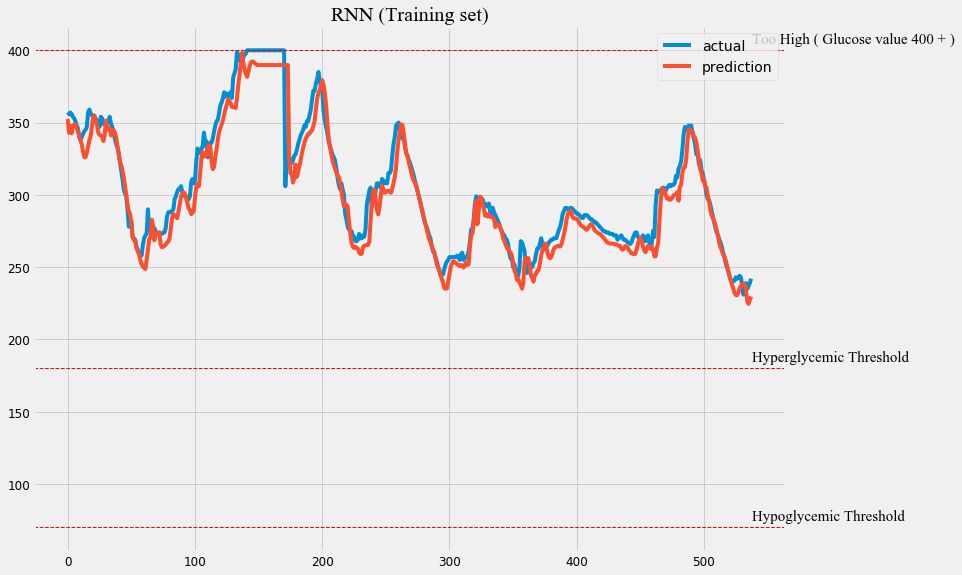

In [121]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [122]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [123]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


In [124]:
model.compile(optimizer='adam',loss='mse')

In [125]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [126]:
K.clear_session()

In [127]:
predict_result = model.predict(x_val_single,verbose=0)

In [128]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [129]:
#predict_result

In [130]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_lstm_15=RMSE(y_val_single,predict_result)

 LSTM - RMSE (15min) :  8.830861


In [131]:
TRAIN_SPLIT

544

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

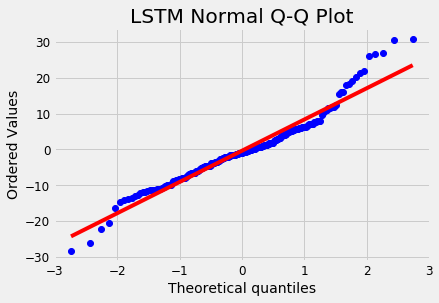

In [132]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

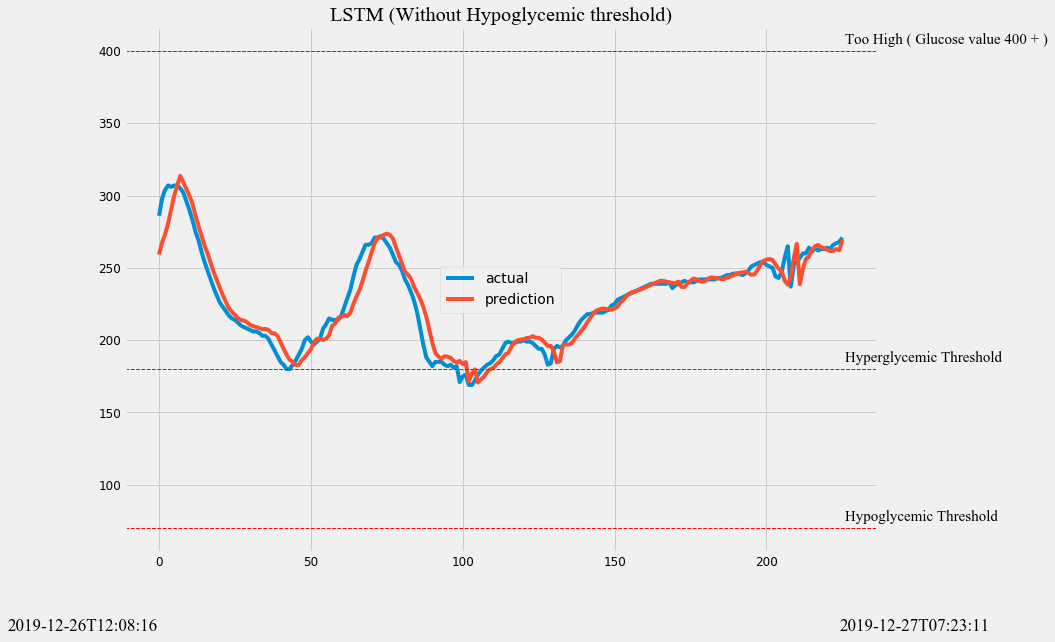

In [133]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [134]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_15 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (15min) Training set :  10.533011


#### Train

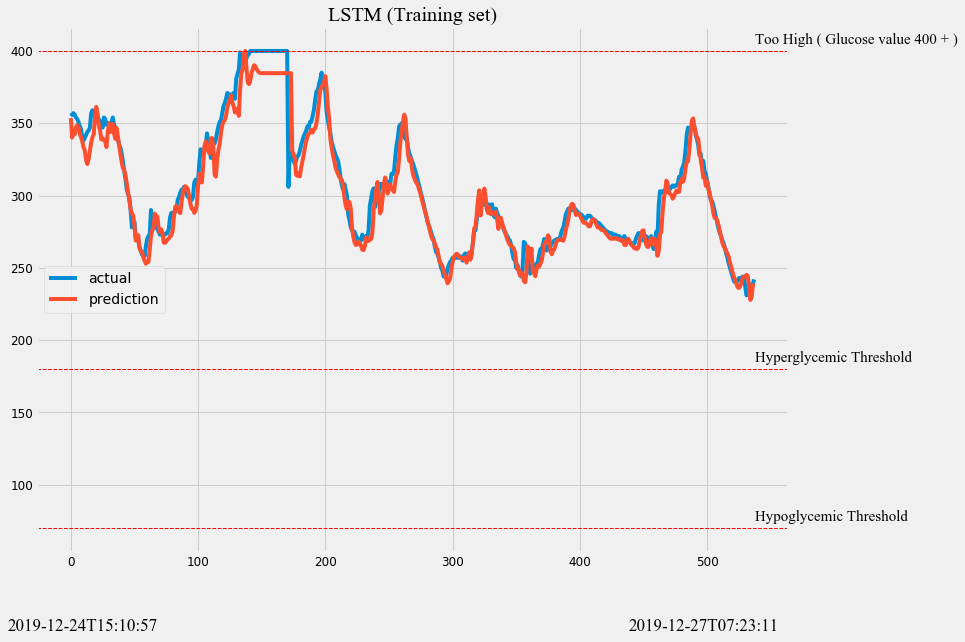

In [135]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [136]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [137]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [138]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [139]:
K.clear_session()

In [140]:
predict_result = model.predict(x_val_single,verbose=0)


In [141]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [142]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_15 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  9.476698


#### Validation

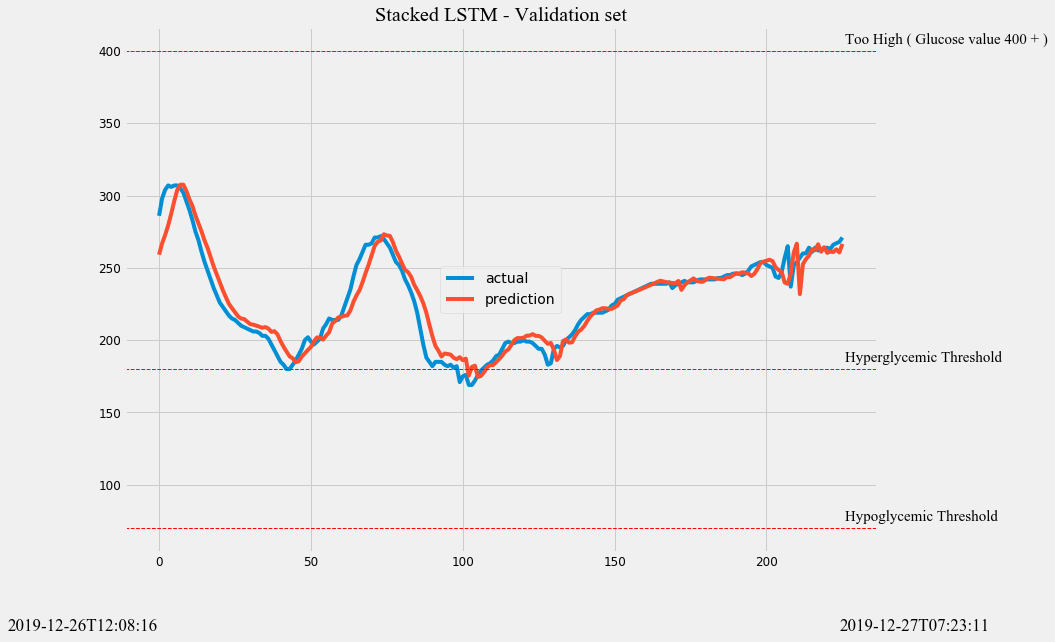

In [143]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

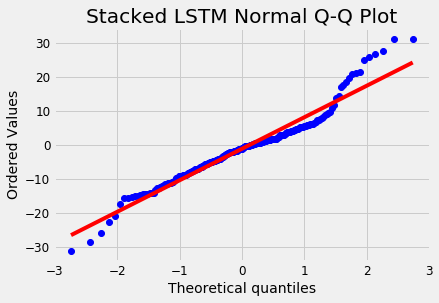

In [144]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [145]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_15 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  10.422372


#### Train

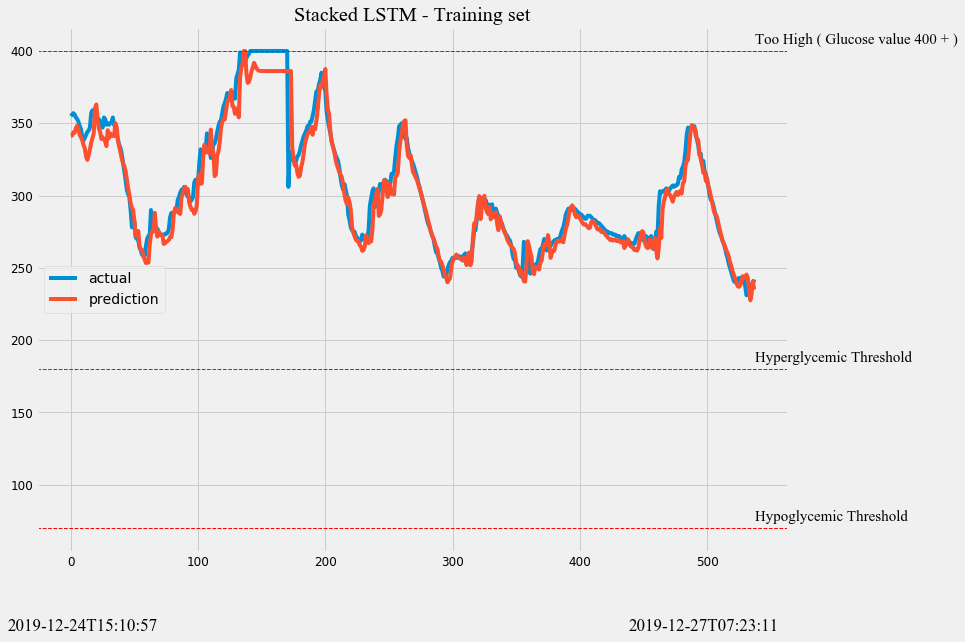

In [146]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [147]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [148]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [149]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [150]:
K.clear_session()

In [151]:
predict_result = model.predict(x_val_single,verbose=0)

In [152]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [153]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_15 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  8.993172


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

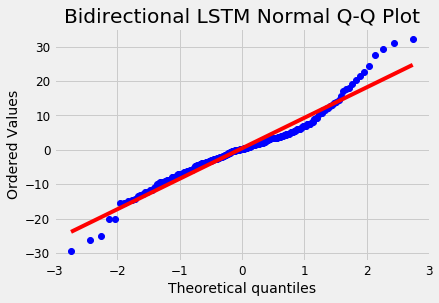

In [154]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

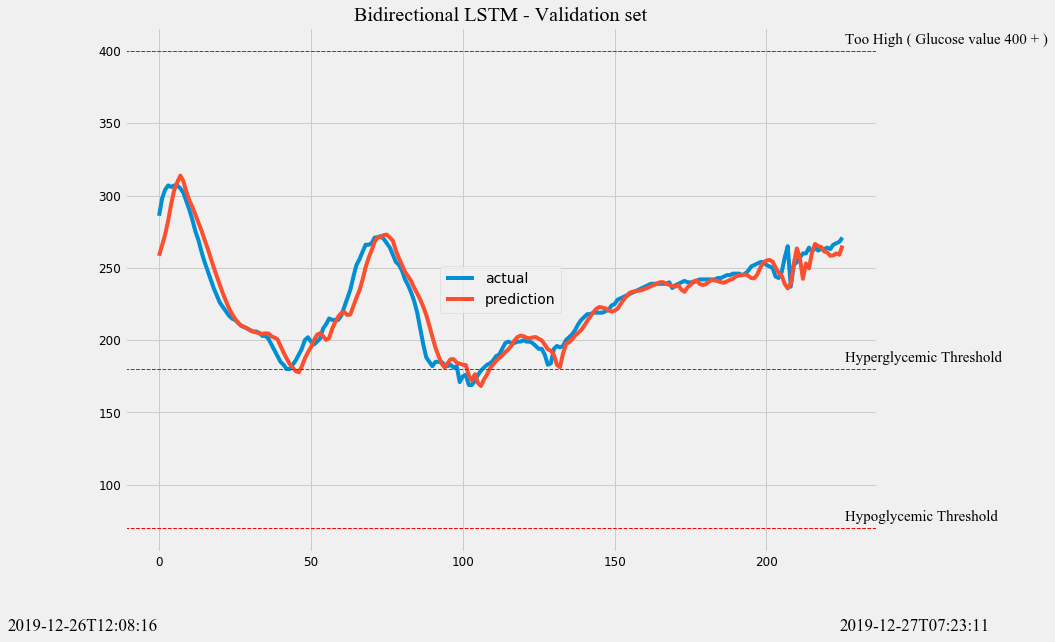

In [155]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [156]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_15 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  11.918337


#### Train

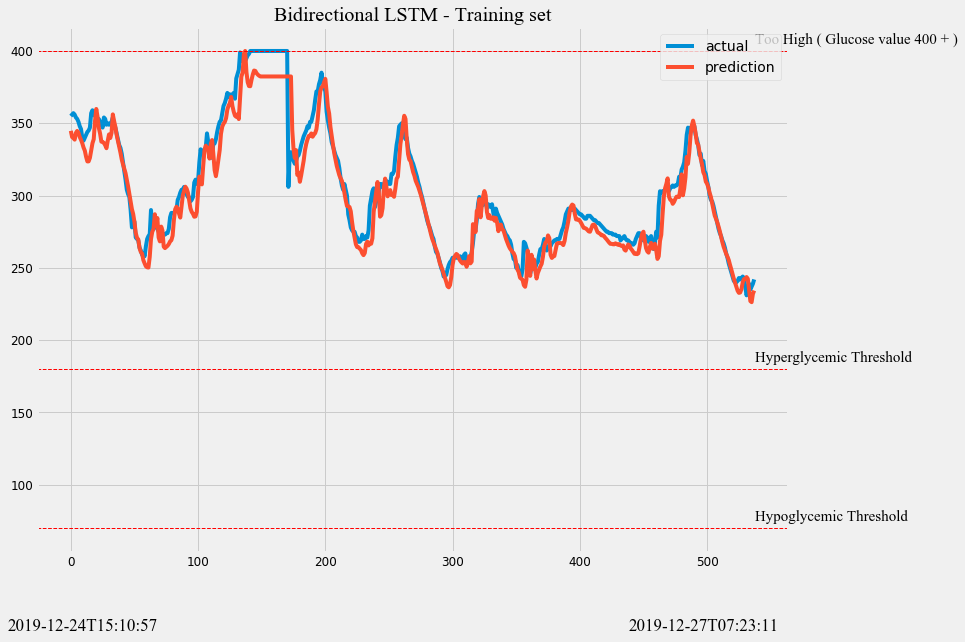

In [157]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [158]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [159]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [160]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [162]:
K.clear_session()

In [163]:
predict_result = model.predict(x_val_single,verbose=0)

In [164]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [165]:
#predict_result

In [166]:
#predict_result

In [167]:

print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_15 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  9.69585


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

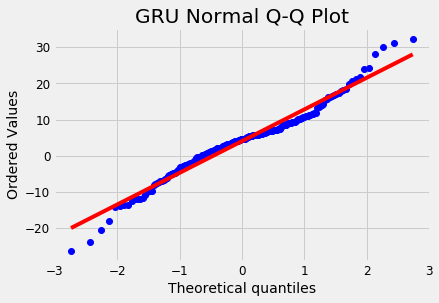

In [168]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

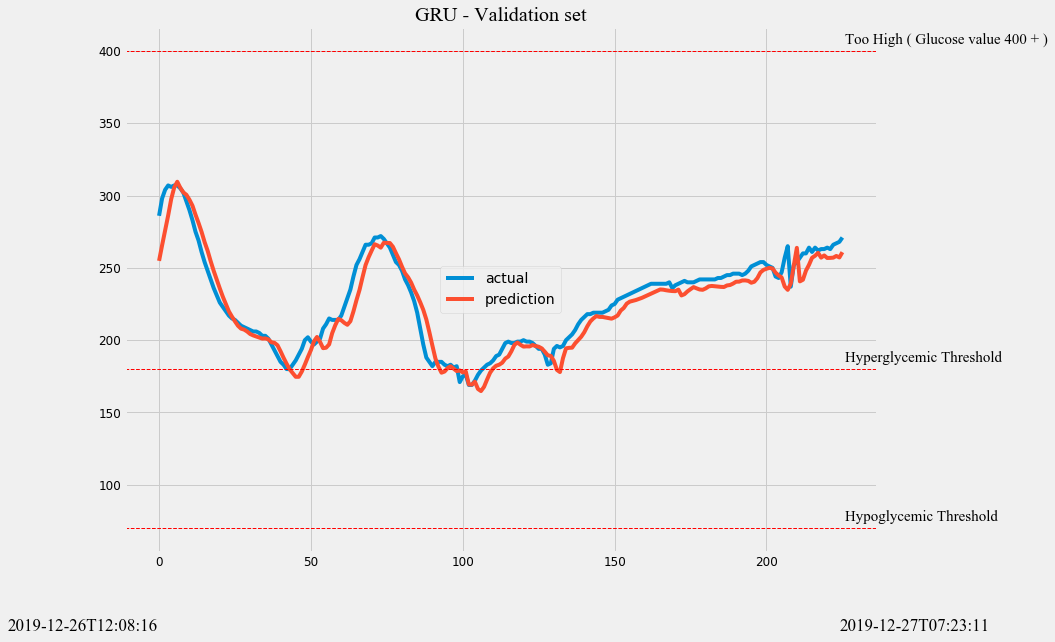

In [169]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [170]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_15 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (15min) Training set :  11.756388


#### Train

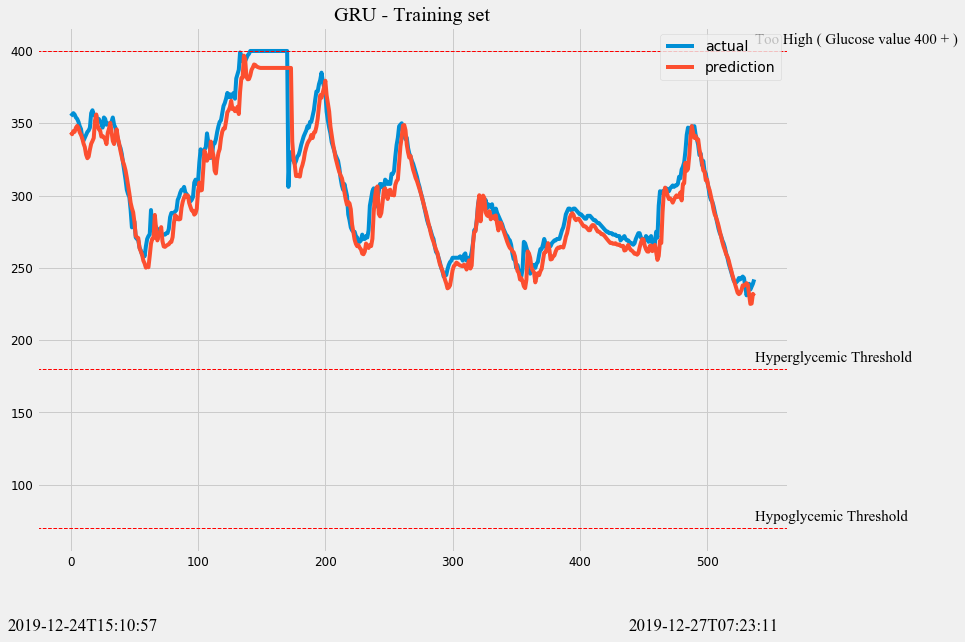

In [171]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [172]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [173]:
#residuals.plot(kind='kde')

In [174]:
#residuals.plot()

In [175]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

## 30분

In [176]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 5
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [177]:
#x_train_uni.shape


In [178]:

#x_val_uni.shape

In [179]:
#x_train_uni[0]

In [180]:
#df['Glucose'].head(15)

In [181]:
#y_train_uni[0]

### RNN - 30분

In [182]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [183]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [184]:
model.compile(optimizer='adam',loss='mse')

In [185]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [186]:
K.clear_session()

In [187]:
predict_result = model.predict(x_val_single,verbose=0)

In [188]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [189]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_30 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  15.723925


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

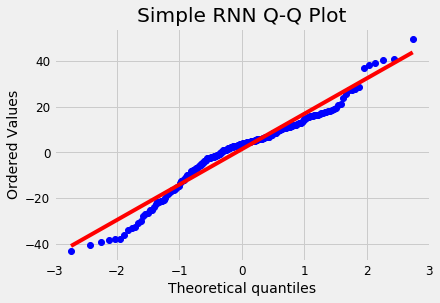

In [190]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

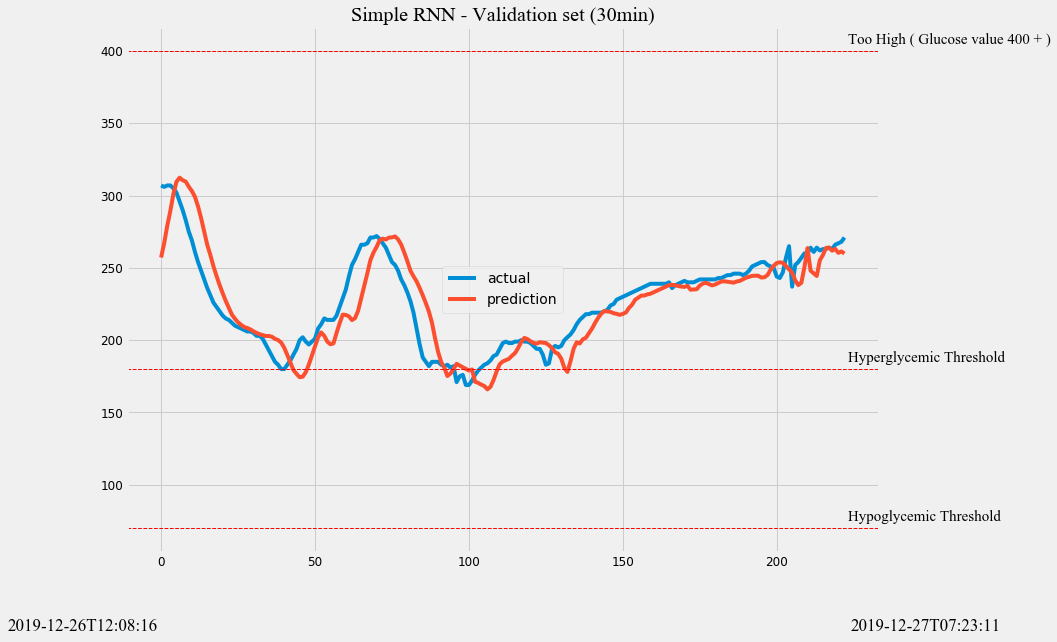

In [191]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

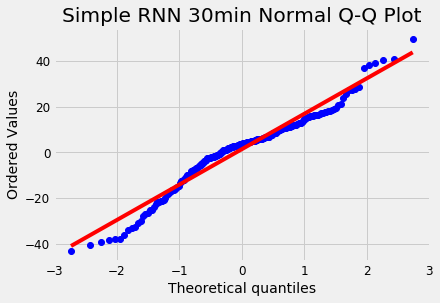

In [192]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [193]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_30=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  15.9741955


#### Train

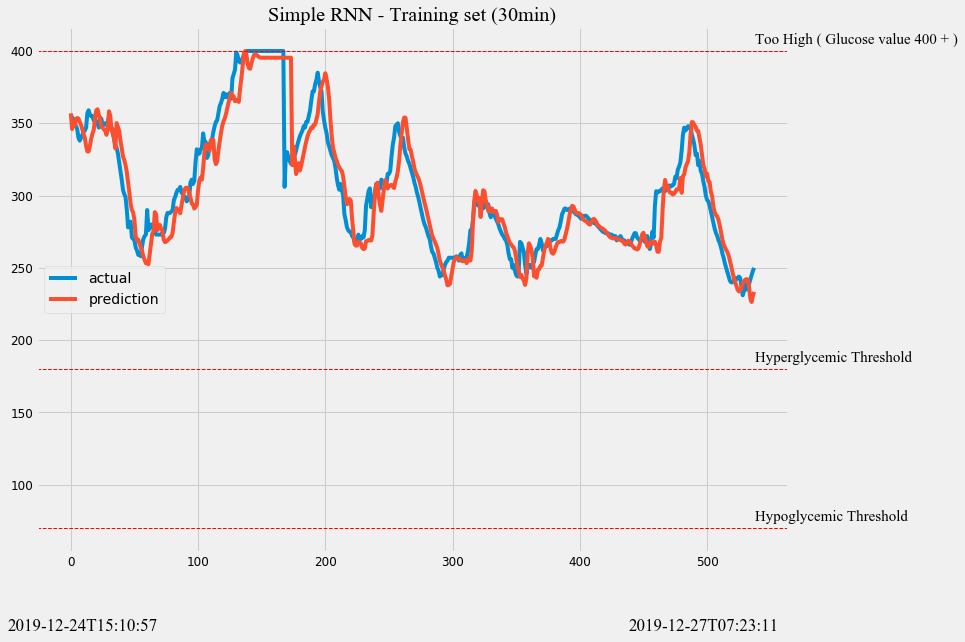

In [194]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [195]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [196]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


In [197]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [198]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_lstm_30=RMSE(y_val_single,predict_result)

 LSTM - RMSE (15min) :  16.365564


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

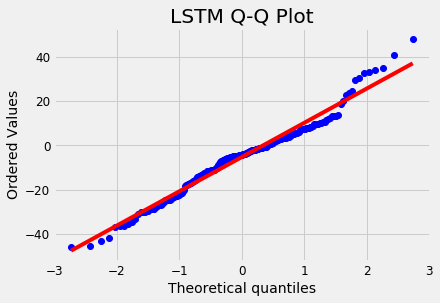

In [199]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

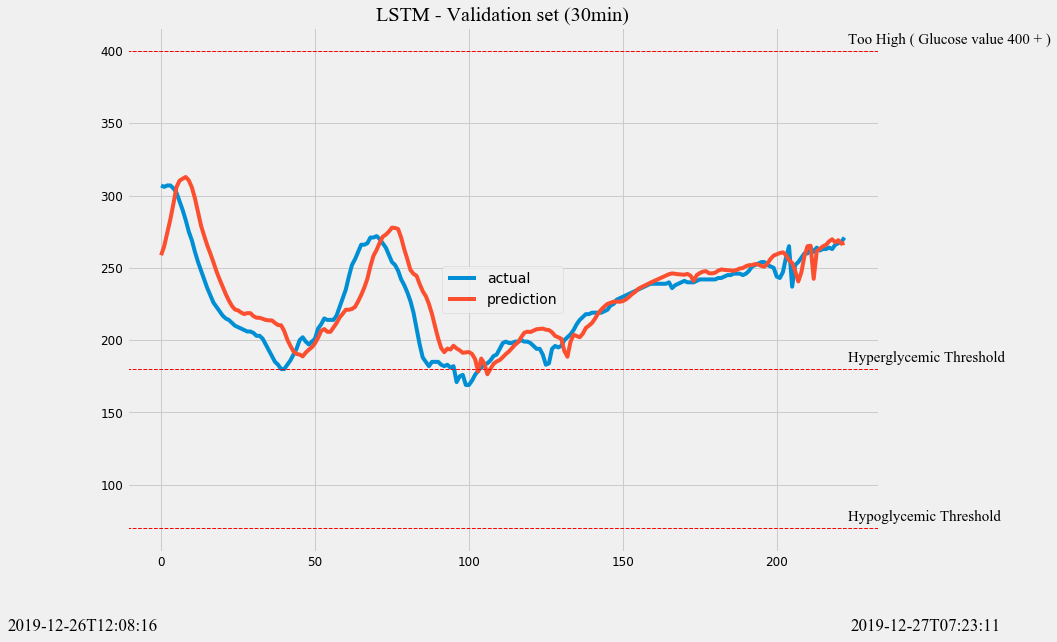

In [200]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [201]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_30 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (15min) Training set :  14.700889


#### Train

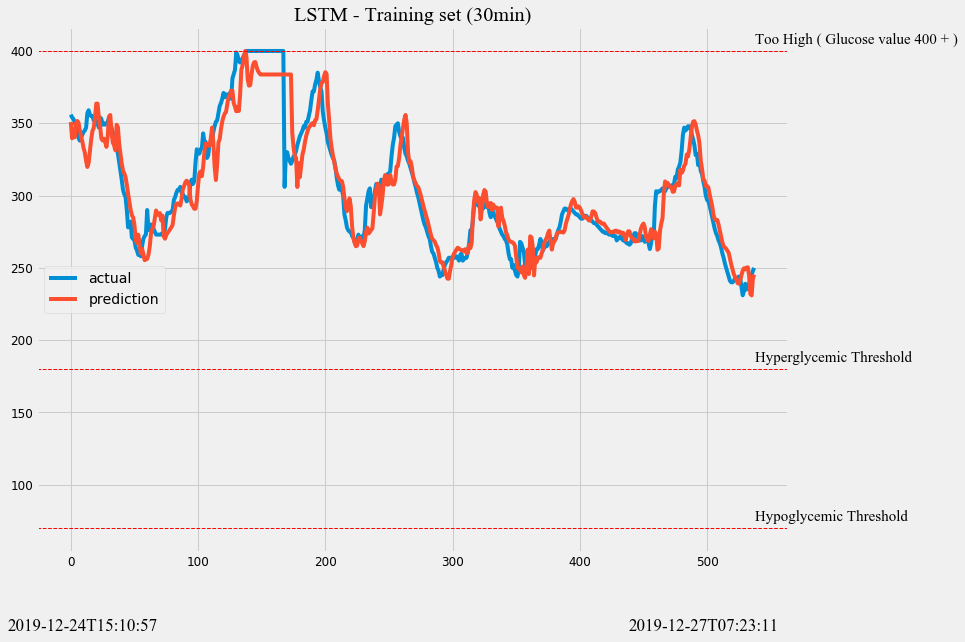

In [202]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [203]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [204]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [205]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [206]:
K.clear_session()

In [207]:
predict_result = model.predict(x_val_single,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_30 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  15.699814


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

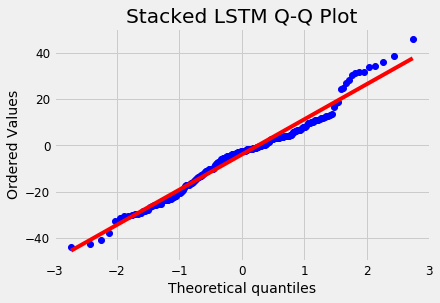

In [208]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

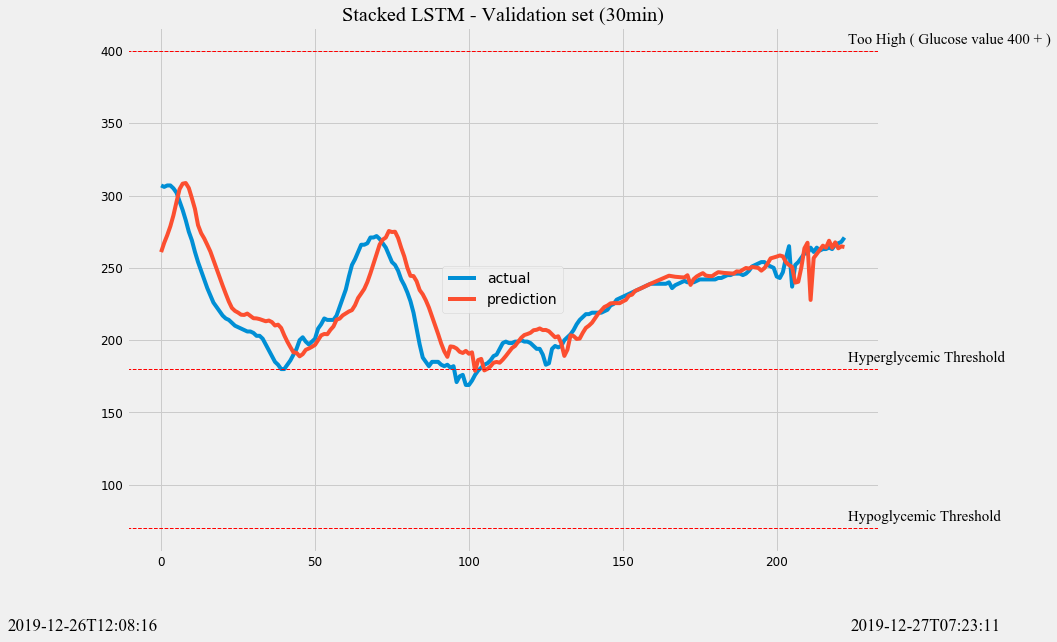

In [209]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [210]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_30 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  14.953966


#### Train

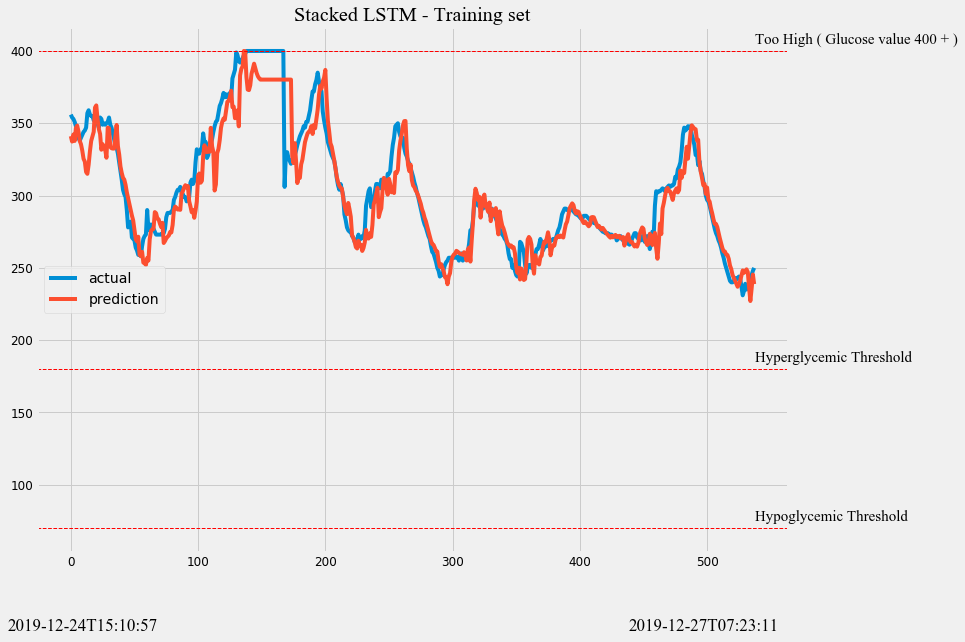

In [211]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [212]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [213]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [214]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [215]:
K.clear_session()

In [216]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_30 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  15.732971


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

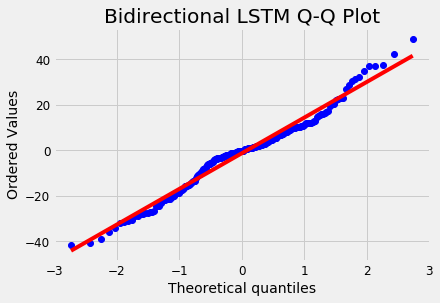

In [217]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

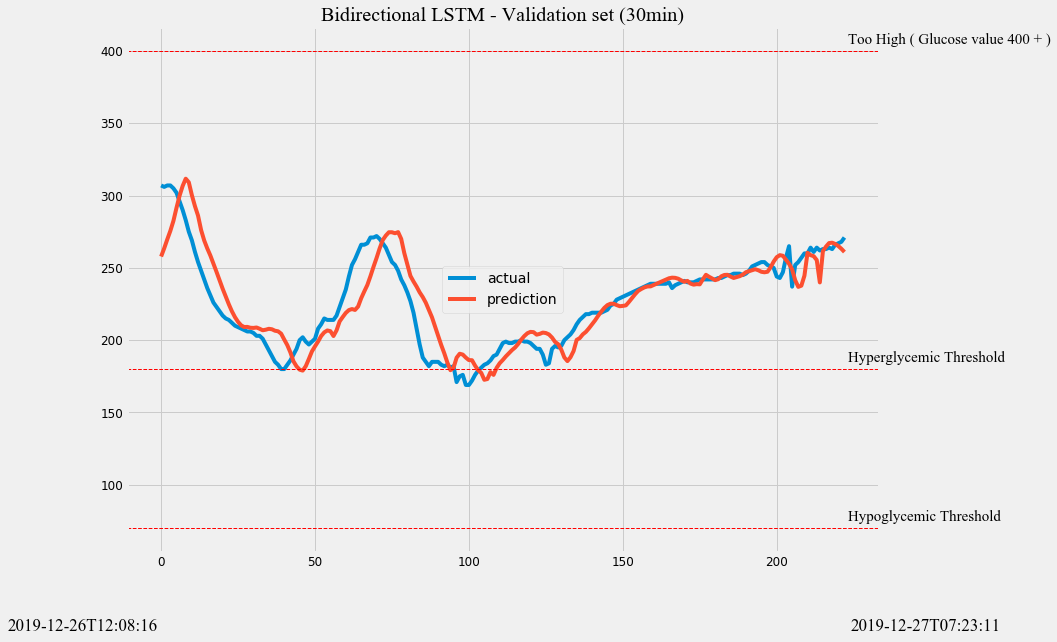

In [218]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [219]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_30 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  17.538063


#### Train

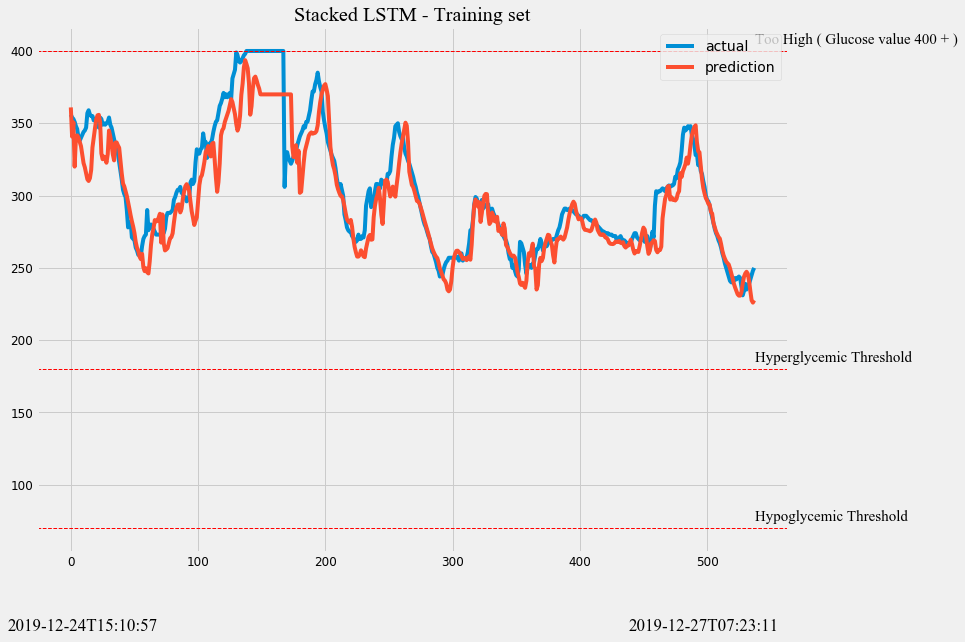

In [220]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [221]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [222]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [223]:
model.summary()

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [224]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_30 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  17.592098


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

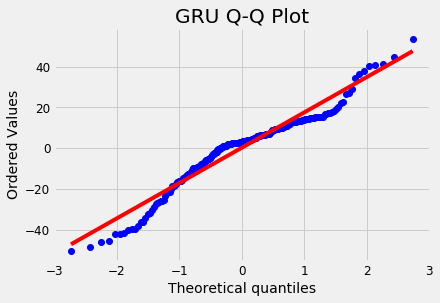

In [225]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

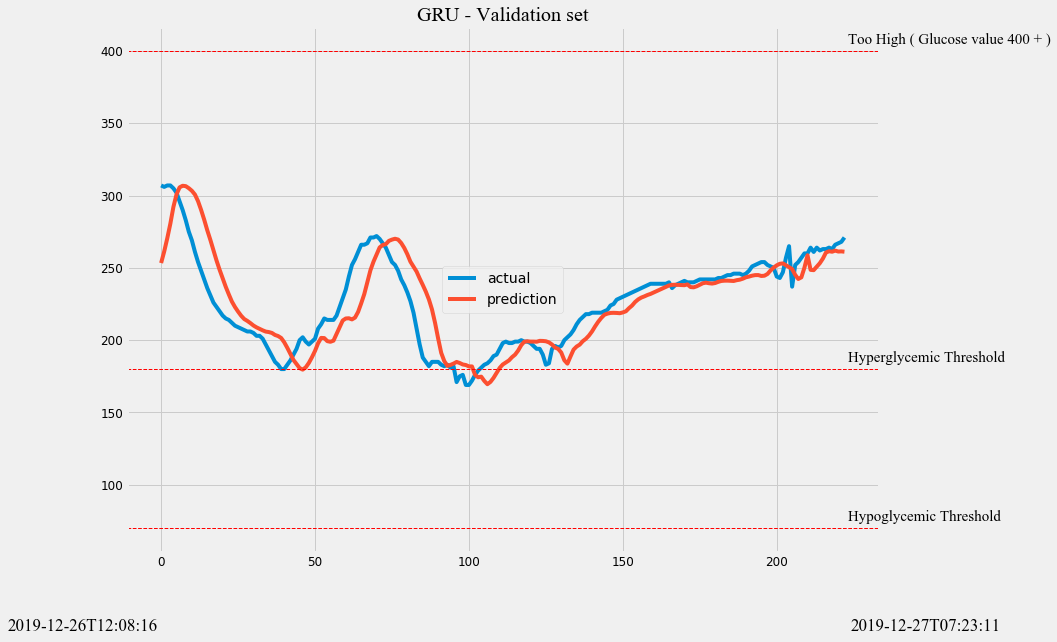

In [226]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [227]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_30 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (15min) Training set :  16.964027


#### Train

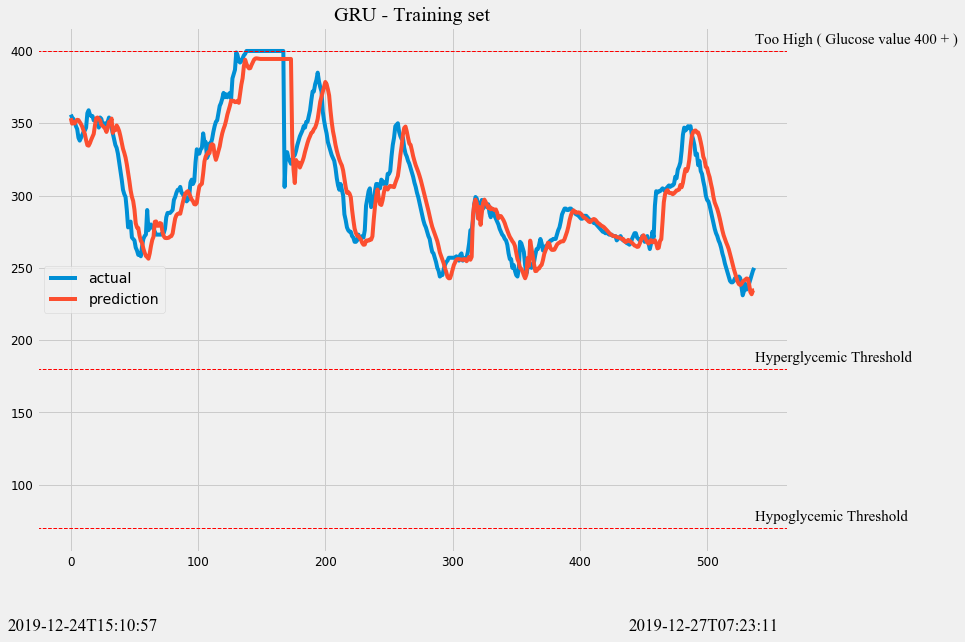

In [228]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [229]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
multi_past_history = 6
multi_future_target = 11
STEP=1
x_train_single, y_train_single = multi_data(dataset,dataset[:,0],0,TRAIN_SPLIT,
                                            multi_past_history,multi_future_target,STEP,single_step=True)
x_val_single, y_val_single = multi_data(dataset, dataset[:,0],TRAIN_SPLIT,
                                        None,multi_past_history,multi_future_target,STEP,single_step=True)

In [230]:
#x_train_uni[0]

In [231]:
#y_train_uni[0]

In [232]:
#df['Glucose'].head(20)

### RNN - 60분

In [233]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [234]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_single.shape[-2:],return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

In [235]:
K.clear_session()

In [236]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_single,predict_result))
val_rnn_60 = RMSE(y_val_single,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  29.093735


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

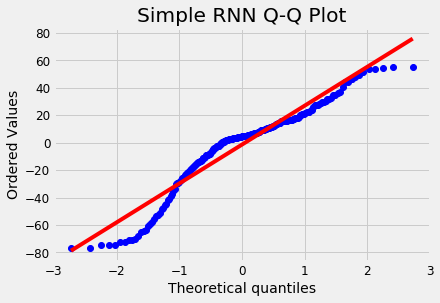

In [237]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

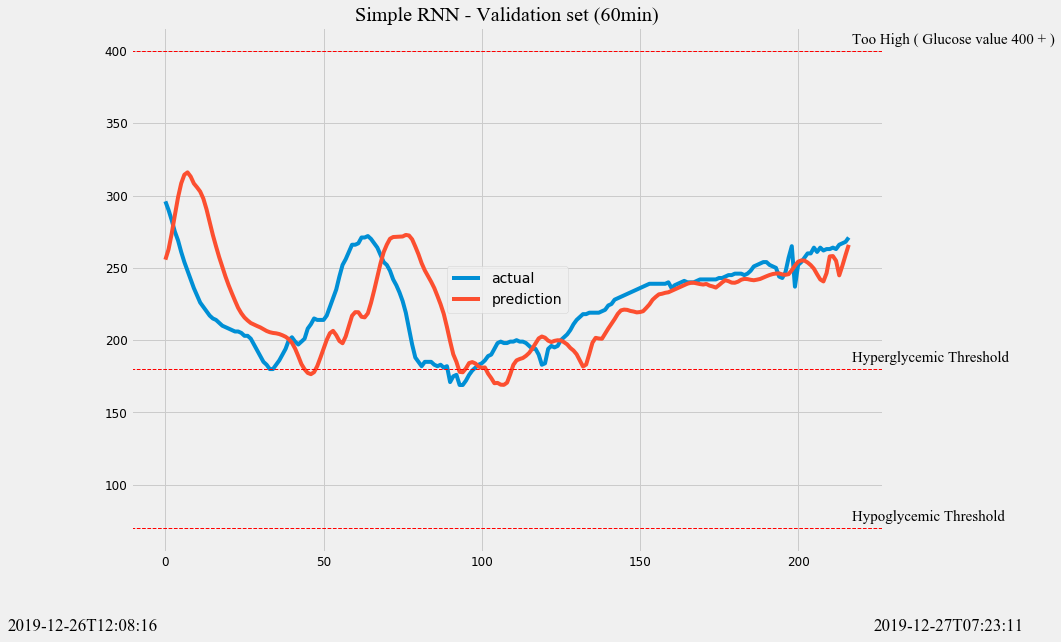

In [238]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

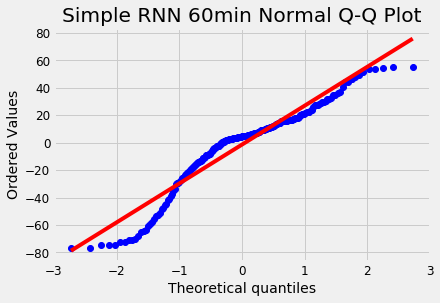

In [239]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [240]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_single,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_single,predict_result))
train_rnn_60=RMSE(y_train_single,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  26.98556


#### Train

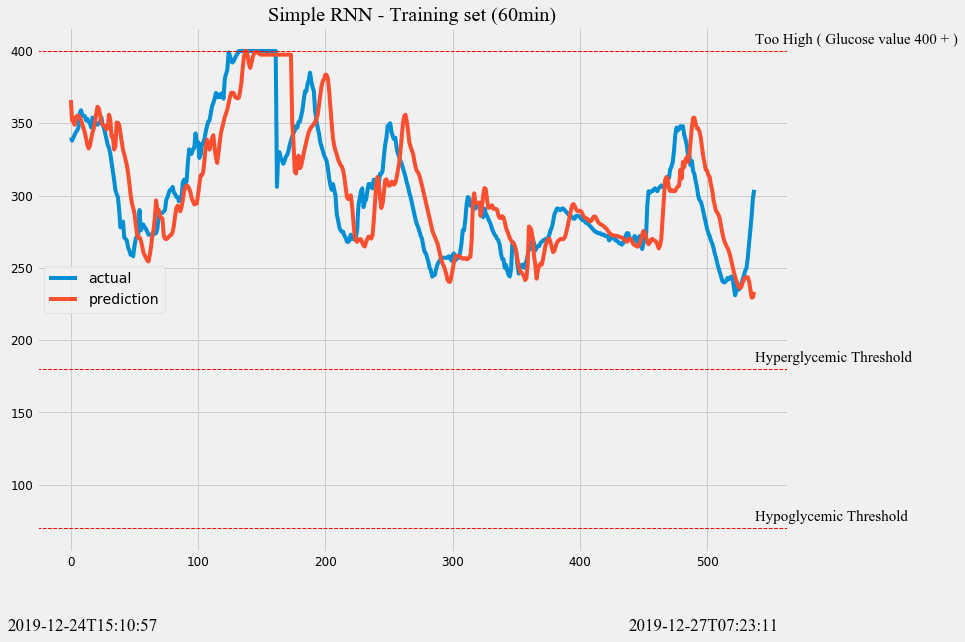

In [241]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [242]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [243]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [244]:
predict_result = model.predict(x_val_single,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_single,predict_result))
val_lstm_60=RMSE(y_val_single,predict_result)

 LSTM - RMSE (60min) :  28.707188


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

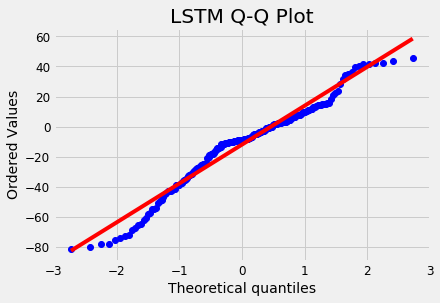

In [245]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

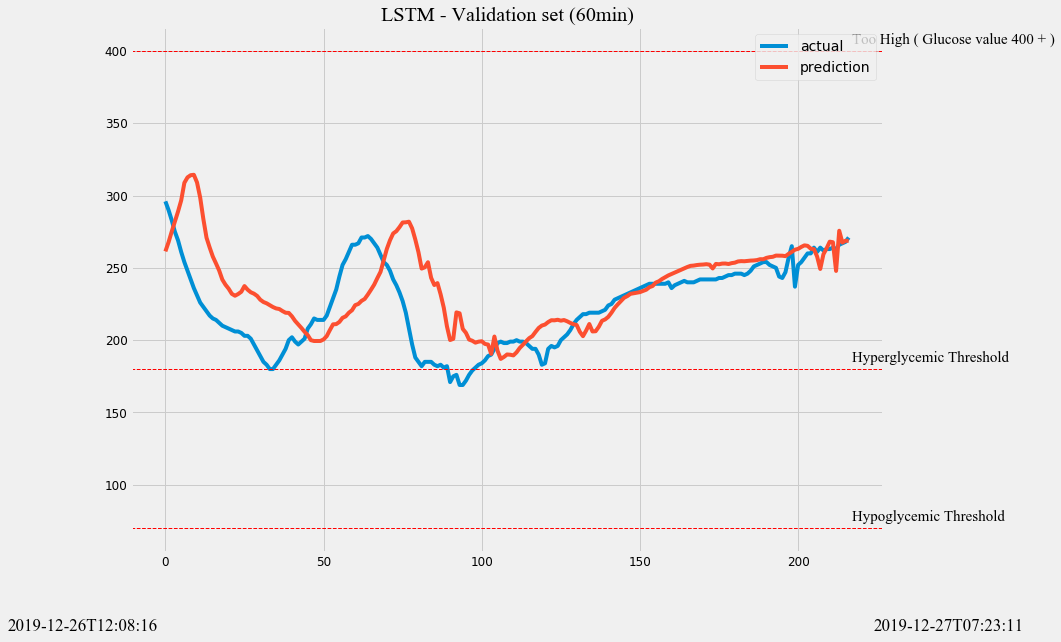

In [246]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [247]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_lstm_60 =RMSE(y_train_single,predict_result)

 LSTM - RMSE (60min) Training set :  22.028362


#### Train

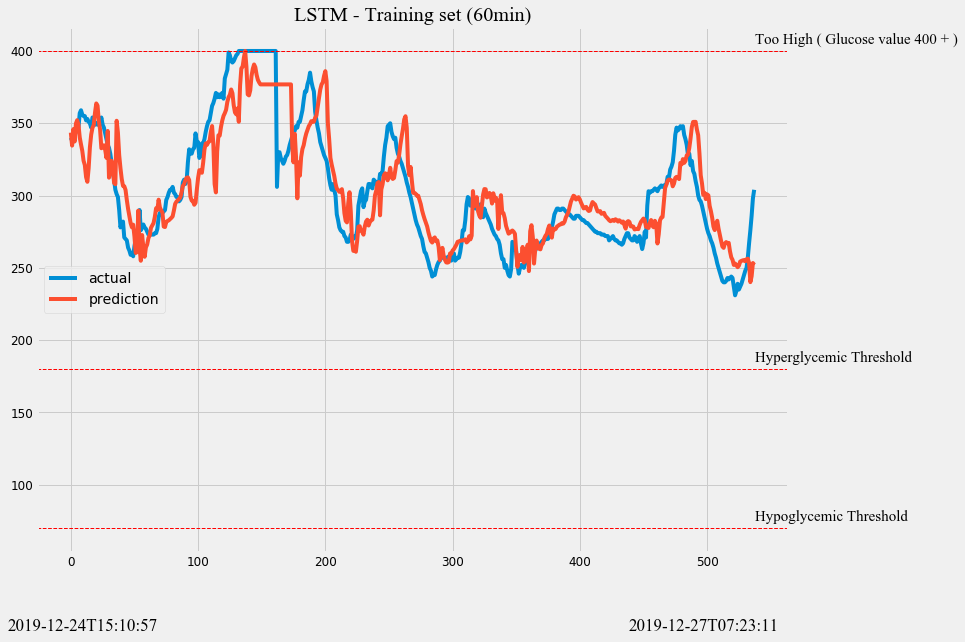

In [248]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [249]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [250]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_single.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [251]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [252]:
predict_result = model.predict(x_val_single,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_single,predict_result))
val_stacklstm_60 =RMSE(y_val_single,predict_result)

 Stacked LSTM - RMSE(15min) :  27.220388


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

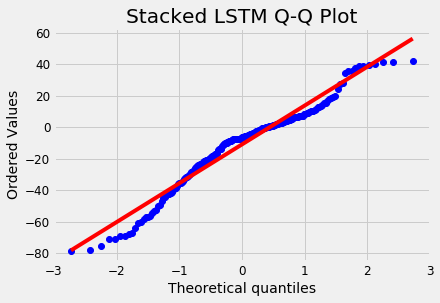

In [253]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

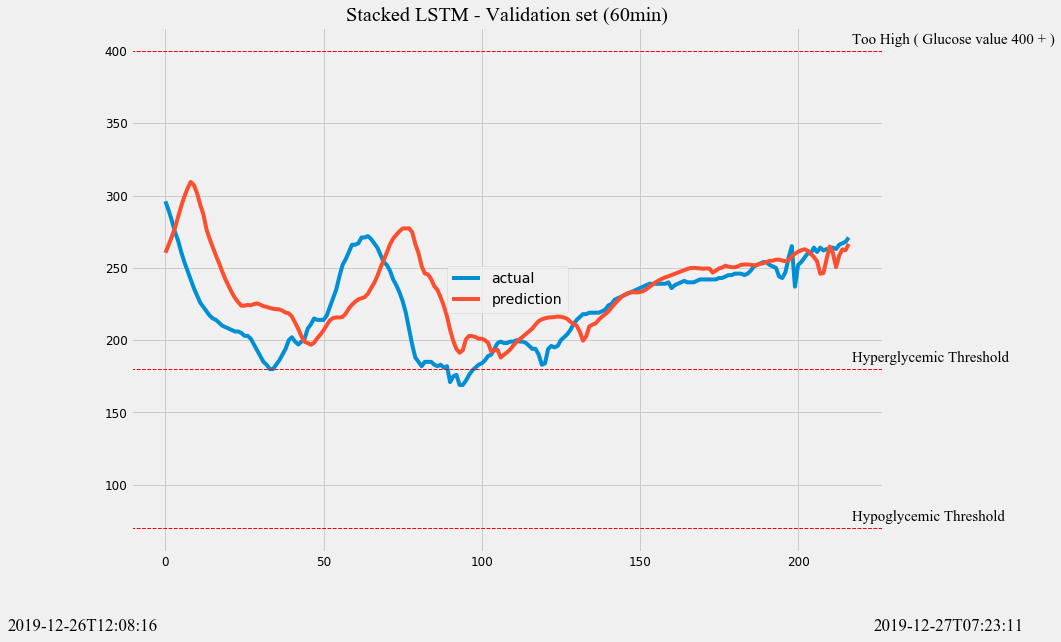

In [254]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [255]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_stacklstm_60 = RMSE(y_train_single,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  24.705076


#### Train

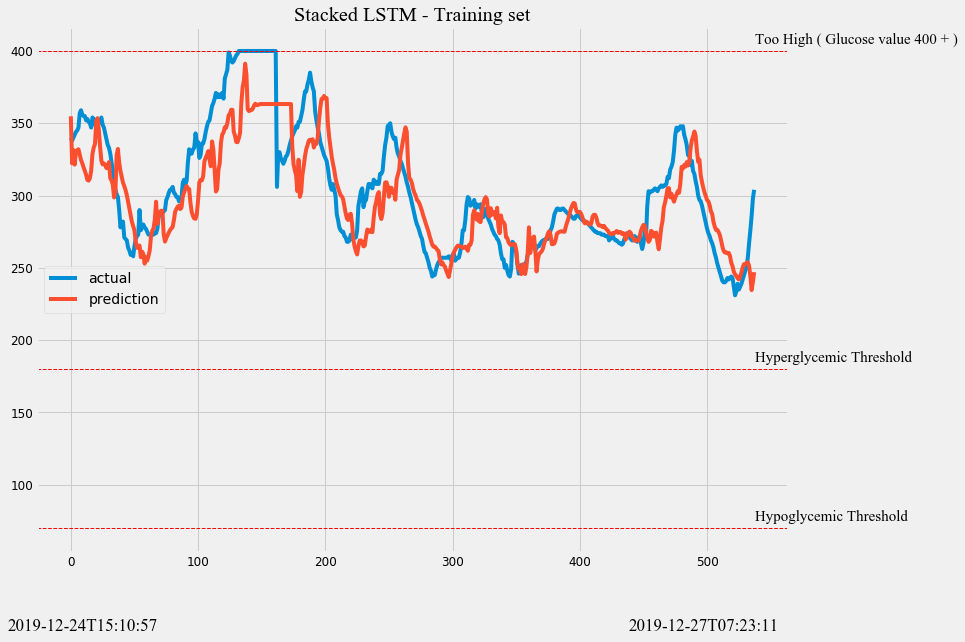

In [256]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [257]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [258]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [259]:
model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

In [260]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_single,predict_result))
val_bilstm_60 = RMSE(y_val_single,predict_result)

Bidirectional LSTM - RMSE :  31.237423


#### Validation

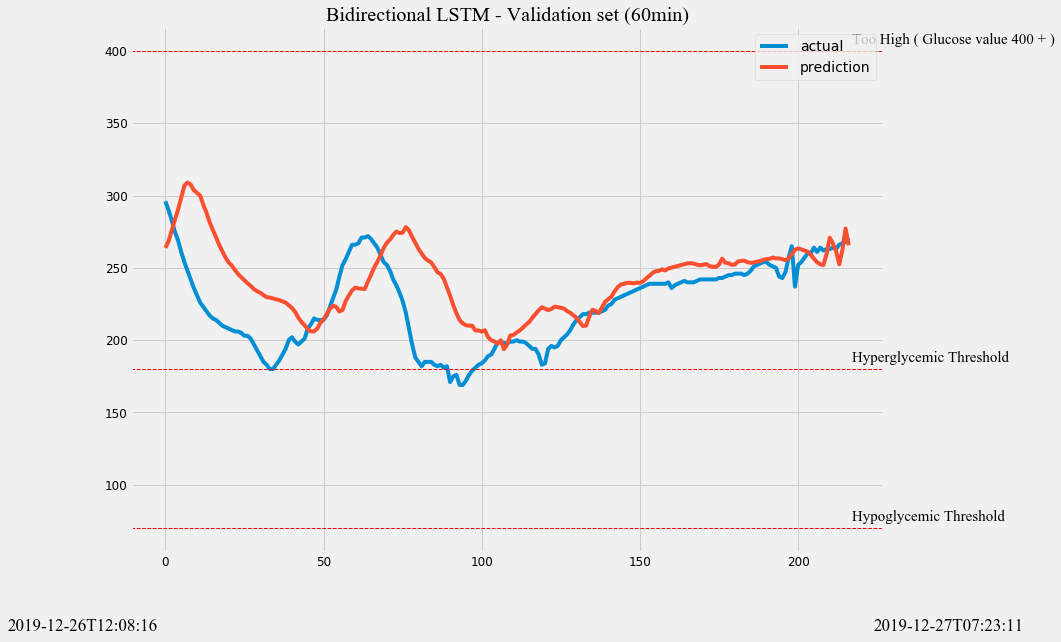

In [261]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

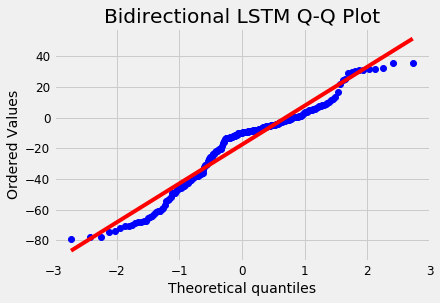

In [262]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [263]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_bilstm_60 = RMSE(y_train_single,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  25.104189


#### Train

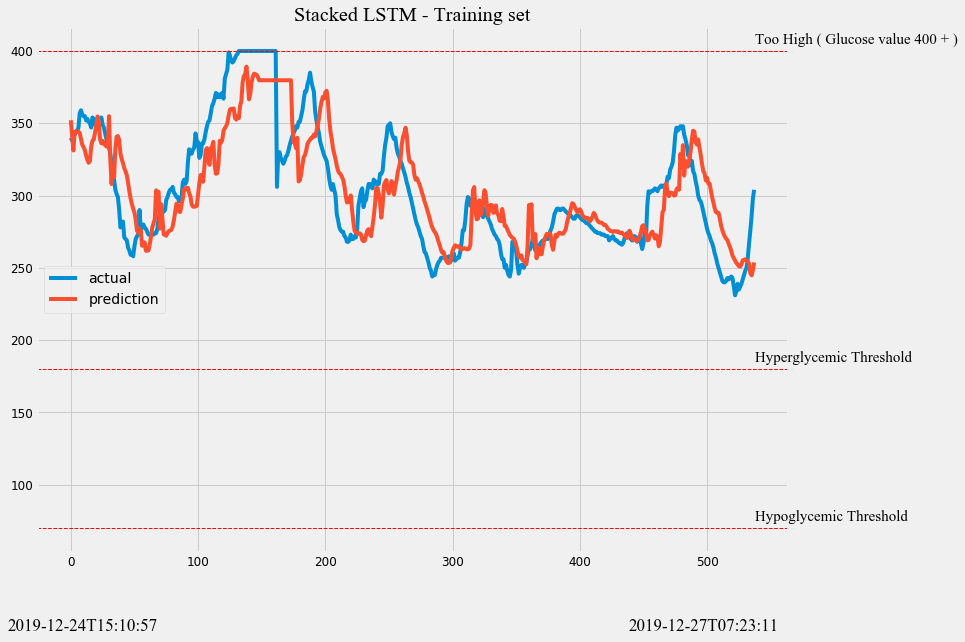

In [264]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [265]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [266]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_single.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [267]:
model.summary()

model.fit(x_train_single,y_train_single,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                8250      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,301
Trainable params: 8,301
Non-trainable params: 0
_________________________________________________________________


In [268]:
predict_result = model.predict(x_val_single,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_single,predict_result))
val_gru_60 = RMSE(y_val_single,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  29.185032


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

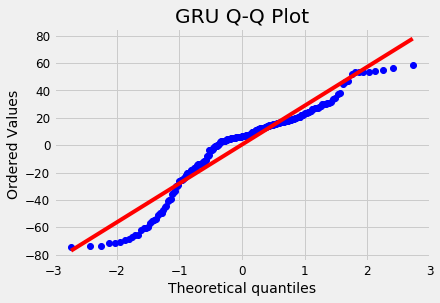

In [269]:
residuals = [y_val_single[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_single - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

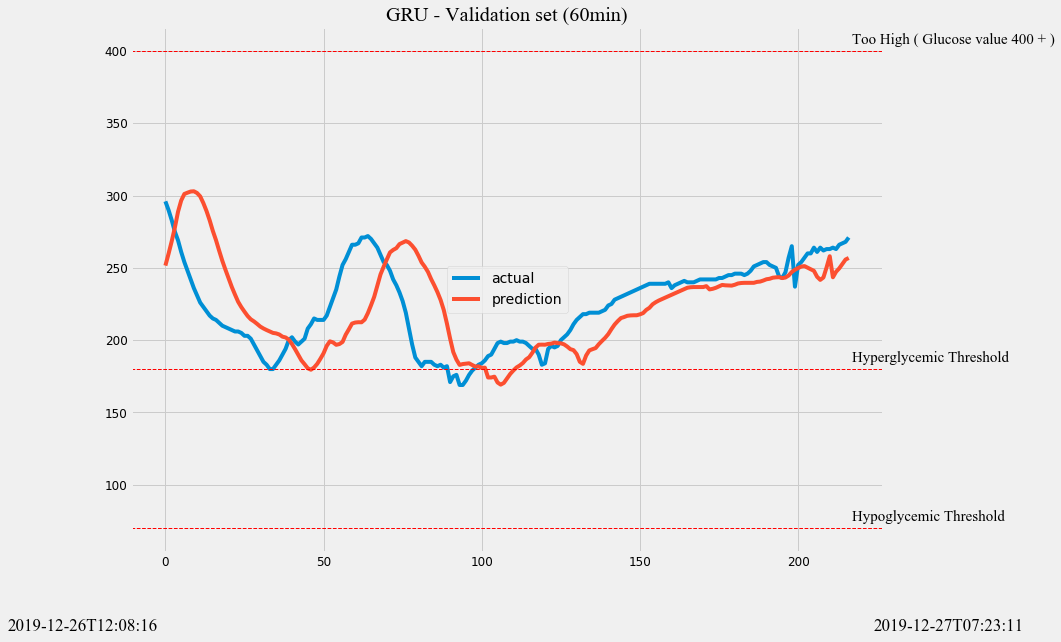

In [270]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [271]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_single,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_single,predict_result))
train_gru_60 =RMSE(y_train_single,predict_result)

 Training set / GRU - RMSE (60min) Training set :  27.386078


#### Train

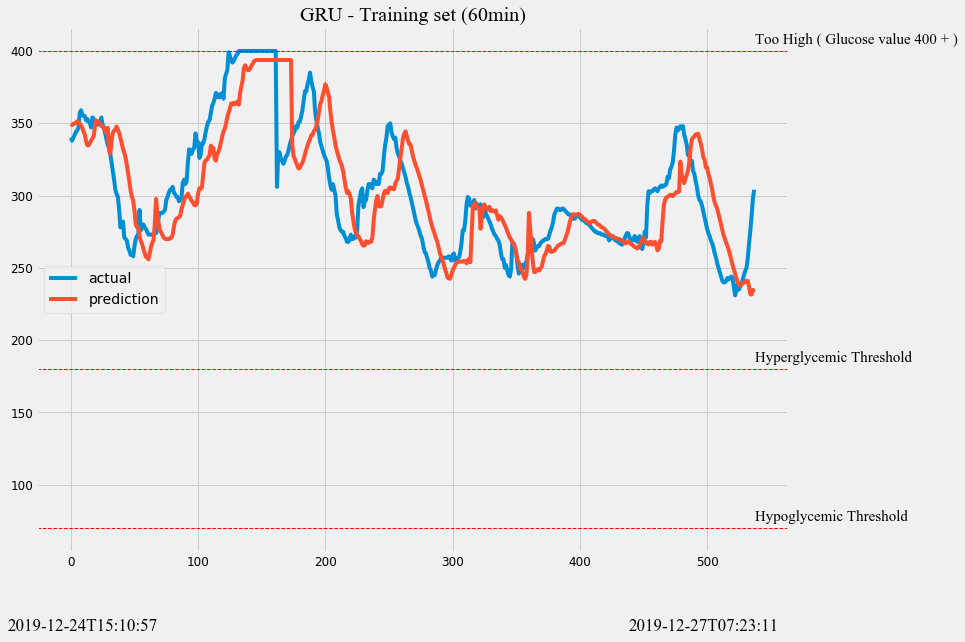

In [272]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_single,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [273]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [274]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [275]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [276]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [277]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [278]:
val_result_list

[[10.255667, 15.723925, 29.093735],
 [8.830861, 16.365564, 28.707188],
 [9.476698, 15.699814, 27.220388],
 [8.993172, 15.732971, 31.237423],
 [9.69585, 17.592098, 29.185032]]

In [279]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

,15 MIN,30 MIN,60 MIN
RNN,10.255667,15.723925,29.093735
LSTM,8.830861,16.365564,28.707188
Stacked LSTM,9.476698,15.699814,27.220388
Bidirectional LSTM,8.993172,15.732971,31.237423
GRU,9.695850,17.592098,29.185032


In [280]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

,15 MIN,30 MIN,60 MIN
RNN,12.007007,15.974195,26.985559
LSTM,10.533011,14.700889,22.028362
Stacked LSTM,10.422372,14.953966,24.705076
Bidirectional LSTM,11.918337,17.538063,25.104189
GRU,11.756388,16.964027,27.386078


## CNN LSTM